In [4]:
using Revise
push!(LOAD_PATH,"../src/")
using ProgressBars
using Random
using ITensors,ITensorMPS
using PastaQ
using TimerOutputs
using RandomMeas
using StatsBase

In [5]:
#Perform RM in the first experiment
N = 8
ξ = siteinds("Qubit", N)

p,dp = 0.05,0.02
p_vec = [max(0, min(p + dp * randn(), 1)) for i in 1:N]
G = 1 .-p_vec/2

circuit = randomcircuit(N, depth=2)
states = ["Dn" for n in 1:N]
ψ0  = MPS(ComplexF64,ξ,states)
#
ρ0 = outer(ψ0',ψ0)
ρ0n = copy(ρ0)
Apply_depo_channel!(ρ0n,ξ,p_vec)

#
ρ = runcircuit(ρ0,circuit)
ρn = copy(ρ)
Apply_depo_channel!(ρn,ξ,p_vec)
#ρ = runcircuit(circuit;noise = noisemodel);
println("state prepared in the `experiment' 1 ")
#RM on a calibration state


nu=1000 #Number of random unitaries
NM=10000 #Number of projective measurements per unitary
datat = zeros(Int8,(NM,N));
data = zeros(Int8,(nu,NM,N));

state prepared in the `experiment' 1 


In [6]:
#Calibration experiment
Gs = zeros(Float64,N)
for r in ProgressBar(1:nu, printing_delay=2)
        u = get_rotations(ξ,1) #Haar rotations in A
        get_RandomMeas!(datat,ρ0n,u,NM)
        σu = rotate_b(ρ0,u)
        for i in 1:N
            P = get_Born_data_binary(datat[:,i:i],ξ[i:i])
            σui,ξi = reduce_dm(σu,collect(i:i))
            Pσ = get_Born(σui)
            Gs[i] += real((3*(P-Pσ)*Pσ)[]+1)/nu
        end
end
println(G)
println(Gs)

0.0%┣                                             ┫ 0/1.0k [00:00<00:00, -0s/it]
12.6%┣█████▎                                    ┫ 126/1.0k [00:02<00:14, 62it/s]
27.8%┣███████████▊                              ┫ 278/1.0k [00:04<00:10, 69it/s]
44.1%┣██████████████████▌                       ┫ 441/1.0k [00:06<00:08, 73it/s]
58.8%┣████████████████████████▊                 ┫ 588/1.0k [00:08<00:06, 73it/s]
73.2%┣██████████████████████████████▊           ┫ 732/1.0k [00:10<00:04, 73it/s]
88.6%┣█████████████████████████████████████▏    ┫ 886/1.0k [00:12<00:02, 73it/s]


[0.9785754084001469, 0.9603470456509012, 0.9726600494439743, 0.9792835556257325, 0.9772524807140587, 0.9724971199175882, 0.9661238930120862, 0.9867170321776179]
[0.9782711060575248, 0.9585883095928889, 0.9728565102875922, 0.9796922295101291, 0.9775517709647316, 0.9738681084769234, 0.9663513672925553, 0.986215676221208]


100.0%┣████████████████████████████████████████┫ 1.0k/1.0k [00:14<00:00, 73it/s]
100.0%┣████████████████████████████████████████┫ 1.0k/1.0k [00:14<00:00, 73it/s]


In [7]:
u = Vector{Vector{ITensor}}()
for r in ProgressBar(1:nu, printing_delay=2)
            push!(u,get_rotations(ξ,1)) #generate random unitary
            get_RandomMeas!(datat,ρn,u[r],NM) #data acquisation in simulated quantum device
            data[r,:,:] = datat
end

0.0%┣                                             ┫ 0/1.0k [00:00<00:00, -0s/it]
18.1%┣███████▋                                  ┫ 181/1.0k [00:02<00:09, 90it/s]
38.3%┣████████████████                          ┫ 383/1.0k [00:04<00:06, 95it/s]
58.3%┣████████████████████████▌                 ┫ 583/1.0k [00:06<00:04, 97it/s]
76.7%┣████████████████████████████████▏         ┫ 767/1.0k [00:08<00:02, 95it/s]
96.7%┣████████████████████████████████████████▋ ┫ 967/1.0k [00:10<00:00, 96it/s]
100.0%┣████████████████████████████████████████┫ 1.0k/1.0k [00:10<00:00, 96it/s]
100.0%┣████████████████████████████████████████┫ 1.0k/1.0k [00:10<00:00, 96it/s]


In [8]:
#Non-mitigated
ITensors.disable_warn_order()
purity = zeros(Float64,N)
purity_nonmit = zeros(Float64,N)
purity_mit = zeros(Float64,N)

for NA in ProgressBar(1:N, printing_delay=2)
        purity[NA] = get_purity(ρ,collect(1:NA),ξ)
        uA = [ut[1:NA] for ut in u]
        purity_nonmit[NA] = get_purity_shadows(data[:,:,1:NA],uA,ξ[1:NA])
        purity_mit[NA] = get_purity_shadows(data[:,:,1:NA],uA,ξ[1:NA];G=Gs)

end

0.0%┣                                                ┫ 0/8 [00:00<00:00, -0s/it]
12.5%┣█████▍                                     ┫ 1/8 [00:08<Inf:Inf, InfGs/it]
25.0%┣███████████▊                                   ┫ 2/8 [00:16<01:39, 16s/it]
37.5%┣█████████████████▋                             ┫ 3/8 [00:32<01:21, 16s/it]
50.0%┣███████████████████████▌                       ┫ 4/8 [00:53<01:11, 18s/it]
62.5%┣█████████████████████████████▍                 ┫ 5/8 [01:19<01:00, 20s/it]
75.0%┣███████████████████████████████████▎           ┫ 6/8 [01:52<00:45, 22s/it]
87.5%┣█████████████████████████████████████████▏     ┫ 7/8 [02:34<00:26, 26s/it]
100.0%┣██████████████████████████████████████████████┫ 8/8 [03:40<00:00, 31s/it]
100.0%┣██████████████████████████████████████████████┫ 8/8 [03:40<00:00, 31s/it]


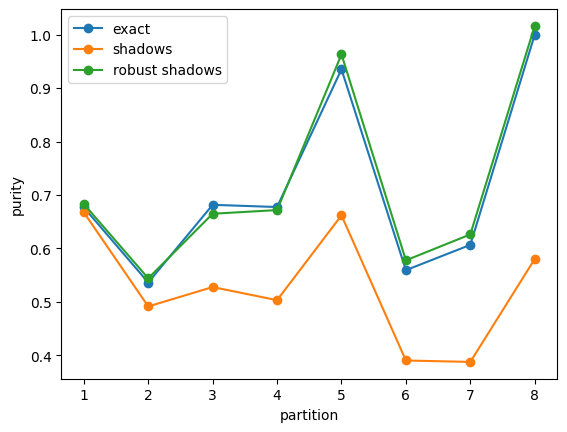

PyObject <matplotlib.legend.Legend object at 0x7f027ad8a710>

In [9]:
using PyPlot
plot(1:N,purity,"-o")
plot(1:N,purity_nonmit,"-o")
plot(1:N,purity_mit,"-o")
xlabel("partition")
ylabel("purity")
legend(["exact","shadows","robust shadows"])